# GPU-Accelerated Bisection Algorithm for Image Segmentation

In [1]:
% load_ext autoreload
% autoreload 2
% matplotlib inline

import time
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pyproximal.optimization.segmentation import *
from scripts._Simplex_numba_ import *
from scripts.Segment_gpu import *

## Simple example of CUDA implementation

In [2]:
# Sign function in CUDA
@cuda.jit
def sign_gpu(x1, c):
    c[0] = x1 / abs(x1)


# c = np.zeros(1)
c = cuda.to_device(np.zeros(1))
sign_gpu[1, 1](1, c);
print(c.copy_to_host())

/home/romerojd/anaconda3/envs/4DProximal/lib/python3.8/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (72) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[1.]


In [3]:
# Operations with matrices

# Multiply a matrix by 2 going row by row
def mult2(A):
    B = np.empty_like(A)
    for i in range(A.shape[0]):
        B[i] = A[i] * 2
    return B


A = np.array(np.random.random(100).reshape((10, 10)), dtype=np.float32)
B = mult2(A)

In [4]:
# Multiply a matrix by 2 going row by row (CUDA)
@cuda.jit(device=True)
def mult2_func(x):
    return 2 * x


@cuda.jit
def mult2_gpu(A, B):
    row_idx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if row_idx < A.shape[0]:
        for j in range(A.shape[1]):
            B[row_idx, j] = mult2_func(A[row_idx, j])


B = np.empty_like(A)
dB = cuda.to_device(B)
dA = cuda.to_device(A)
num_threads_per_blocks = 32
num_blocks = (A.shape[0] + num_threads_per_blocks - 1) // num_threads_per_blocks

mult2_gpu[num_blocks, num_threads_per_blocks](dA, dB)

/home/romerojd/anaconda3/envs/4DProximal/lib/python3.8/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (72) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


## Example 1: Bisection applied to a segmentation matrix of 3 classes

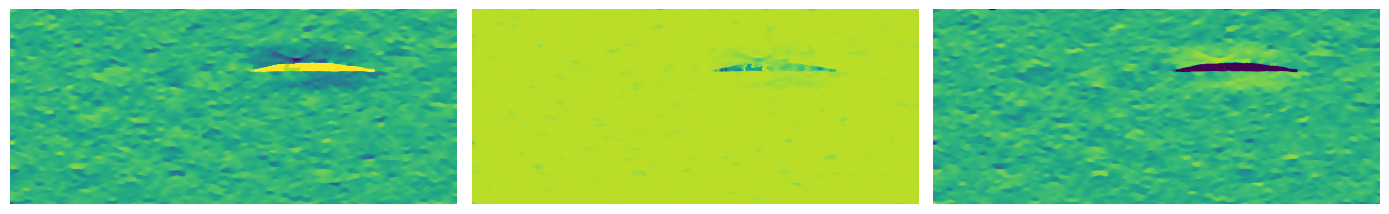

In [7]:
# Segmentation matrix [N_cl * N_dim]
seg_matrix = np.load('data/seg_matrix.npy')

fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ax[0].imshow(seg_matrix.reshape((3, 395, 905))[0], vmin=0.325, vmax=0.335)
ax[0].axis('off')
ax[1].imshow(seg_matrix.reshape((3, 395, 905))[1], vmin=0.325, vmax=0.335)
ax[1].axis('off')
ax[2].imshow(seg_matrix.reshape((3, 395, 905))[2], vmin=0.325, vmax=0.335)
ax[2].axis('off')
fig.tight_layout()

In [4]:
# x_test = cuda.to_device(np.copy(x))
# y = cuda.device_array_like(x_test)

In [8]:
dims = (395, 905)
ndims = len(dims)
dimsprod = np.prod(np.array(dims))
cl = np.array([-0.05, 0, 0.05])
ncl = len(cl)
coeff = np.ones(3)
seg_matrix = seg_matrix.reshape((ncl, dimsprod))
x = seg_matrix.T

#---------------
# Make a bigger a segmentation matrix
n_repeat = 20
x_ = x.reshape((395, 905, 3)).copy()
x_2 = np.zeros((395 * n_repeat, 905 * n_repeat, 3))
for i in range(3):
    x_2[:, :, i] = x_[:, :, i].repeat(n_repeat, axis=0).repeat(n_repeat, axis=1)
x_2 = x_2.reshape((395 * n_repeat, 905 * n_repeat, 3))

### Benchmark bisection

Total time: 1.5794909000396729sec


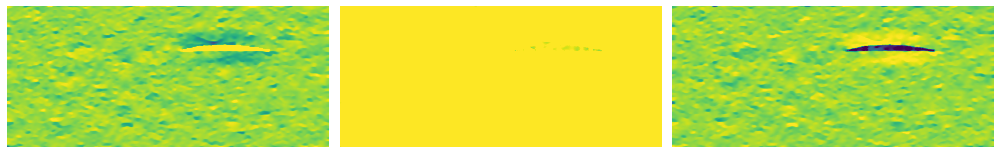

In [52]:
# Benchmark bisection
start = time.time()
v_ = simplex_jit(x, coeff, 1, 0, 10000000000, 10, 1e-8, 1e-8)
end = time.time()

print(f'Total time: {end - start}sec')
v = v_.T
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ax[0].imshow(v.reshape((3, 395, 905))[0], vmin=0.325, vmax=0.335)
ax[0].axis('off')
ax[1].imshow(v.reshape((3, 395, 905))[1], vmin=0.325, vmax=0.335)
ax[1].axis('off')
ax[2].imshow(v.reshape((3, 395, 905))[2], vmin=0.325, vmax=0.335)
ax[2].axis('off')
fig.tight_layout()

Loop over different model sizes

In [26]:
m_time1 = []
model_size = [25, 50, 100, 200, 300, 400, 500, 600]
for i in model_size:
    #Benchmark bisection
    x_ = x_2[:i, :i, :]
    x_ = x_.reshape((i * i, 3))
    start = time.time()
    v_ = simplex_jit(x_, coeff, 1, 0, 10000000000, 10, 1e-8, 1e-8)
    end = time.time()
    m_time1.append(end - start)

    print(f'Total time for a model of size {i, i} : {end - start}sec')
    # v = v_.T
    # fig, ax = plt.subplots(1,3, figsize=(10,3))
    # ax[0].imshow(v.reshape((3,i,i))[0], vmin=0.325, vmax=0.335)
    # ax[0].axis('off')
    # ax[1].imshow(v.reshape((3,i,i))[1], vmin=0.325, vmax=0.335)
    # ax[1].axis('off')
    # ax[2].imshow(v.reshape((3,i,i))[2], vmin=0.325, vmax=0.335)
    # ax[2].axis('off')
    # fig.tight_layout()
    # plt.show()

# np.save('data/m_time1', m_time1)

Total time for a model of size (25, 25) : 0.001007080078125sec
Total time for a model of size (50, 50) : 0.003793478012084961sec
Total time for a model of size (100, 100) : 0.015446186065673828sec
Total time for a model of size (200, 200) : 0.0608370304107666sec
Total time for a model of size (300, 300) : 0.13909316062927246sec
Total time for a model of size (400, 400) : 0.24406957626342773sec
Total time for a model of size (500, 500) : 0.3860359191894531sec
Total time for a model of size (600, 600) : 0.5951187610626221sec


### GPU implementation

/home/romerojd/anaconda3/envs/4DProximal/lib/python3.8/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Total time: 0.022600173950195312sec


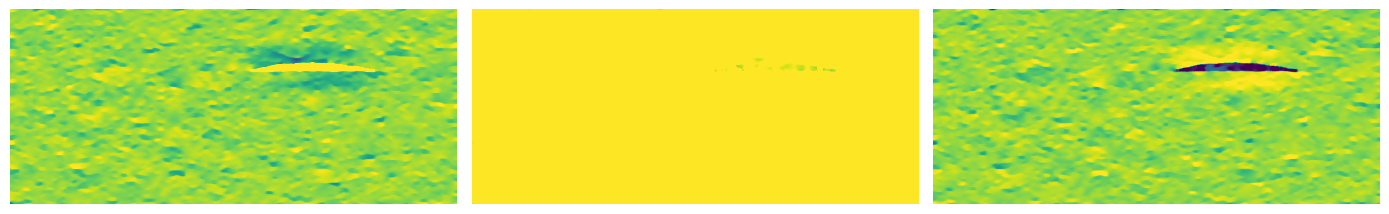

In [51]:
num_threads_per_blocks = 32
num_blocks = (x.shape[0] + num_threads_per_blocks - 1) // num_threads_per_blocks
v = np.empty_like(x)

start = time.time()
simplex_jit_gpu[num_blocks, num_threads_per_blocks](x, coeff, 1, 0, 10000000000, 10, 1e-8, 1e-8, v)
end = time.time()

print(f'Total time: {end - start}sec')

v_gpu = v.T
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ax[0].imshow(v_gpu.reshape((3, 395, 905))[0], vmin=0.325, vmax=0.335)
ax[0].axis('off')
ax[1].imshow(v_gpu.reshape((3, 395, 905))[1], vmin=0.325, vmax=0.335)
ax[1].axis('off')
ax[2].imshow(v_gpu.reshape((3, 395, 905))[2], vmin=0.325, vmax=0.335)
ax[2].axis('off')
fig.tight_layout()

Loop over different model sizes

In [28]:
m_time2 = []
model_size = [25, 50, 100, 200, 300, 400, 500, 600]
for i in model_size:
    x_ = x_2[:i, :i, :]
    x_ = x_.reshape((i * i, 3))
    num_threads_per_blocks = 32
    num_blocks = (x_.shape[0] + num_threads_per_blocks - 1) // num_threads_per_blocks
    v = np.empty_like(x_)
    start = time.time()
    simplex_jit_gpu[num_blocks, num_threads_per_blocks](x_, coeff, 1, 0, 10000000000, 10, 1e-8, 1e-8, v)
    end = time.time()
    m_time2.append(end - start)
    print(f'Total time for a model of size {i, i} : {end - start}sec')
    # v = v.T
    # fig, ax = plt.subplots(1,3, figsize=(10,3))
    # ax[0].imshow(v.reshape((3,i,i))[0], vmin=0.325, vmax=0.335)
    # ax[0].axis('off')
    # ax[1].imshow(v.reshape((3,i,i))[1], vmin=0.325, vmax=0.335)
    # ax[1].axis('off')
    # ax[2].imshow(v.reshape((3,i,i))[2], vmin=0.325, vmax=0.335)
    # ax[2].axis('off')
    # fig.tight_layout()
    # plt.show()

# np.save('data/m_time2', m_time2)

Total time for a model of size (25, 25) : 0.0036537647247314453sec
Total time for a model of size (50, 50) : 0.0041735172271728516sec
Total time for a model of size (100, 100) : 0.0011026859283447266sec
Total time for a model of size (200, 200) : 0.0019698143005371094sec
Total time for a model of size (300, 300) : 0.003394603729248047sec
Total time for a model of size (400, 400) : 0.004762411117553711sec
Total time for a model of size (500, 500) : 0.0057468414306640625sec
Total time for a model of size (600, 600) : 0.007703065872192383sec


### Comparison

In [34]:
# m_time1 = np.append(np.load('data/m_time1.npy'),195.77446341)
# m_time2 = np.append(np.load('data/m_time2.npy'), 2.663643121719)
m_time1 = np.load('data/m_time1.npy')
m_time2 = np.load('data/m_time2.npy')

model_size = np.array([25, 50, 100, 200, 300, 400, 500, 600])

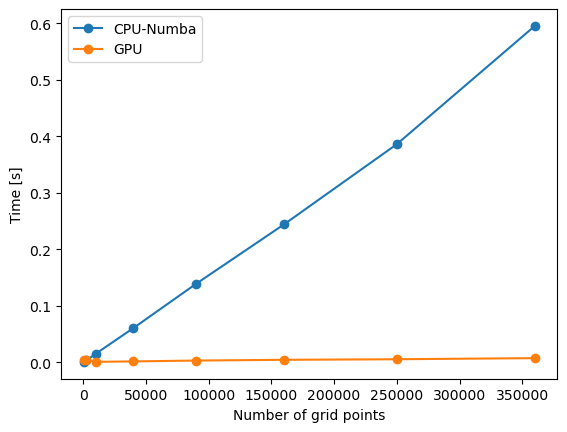

In [35]:
plt.plot(model_size ** 2, m_time1, '-o');
plt.xlabel('Number of grid points')
plt.plot(model_size ** 2, m_time2, '-o');
plt.ylabel('Time [s]')
plt.legend(['CPU-Numba', 'GPU'])

## Example 2: Bisection in the Primal-Dual segmentation algorithm for time-lapse impedance differences.

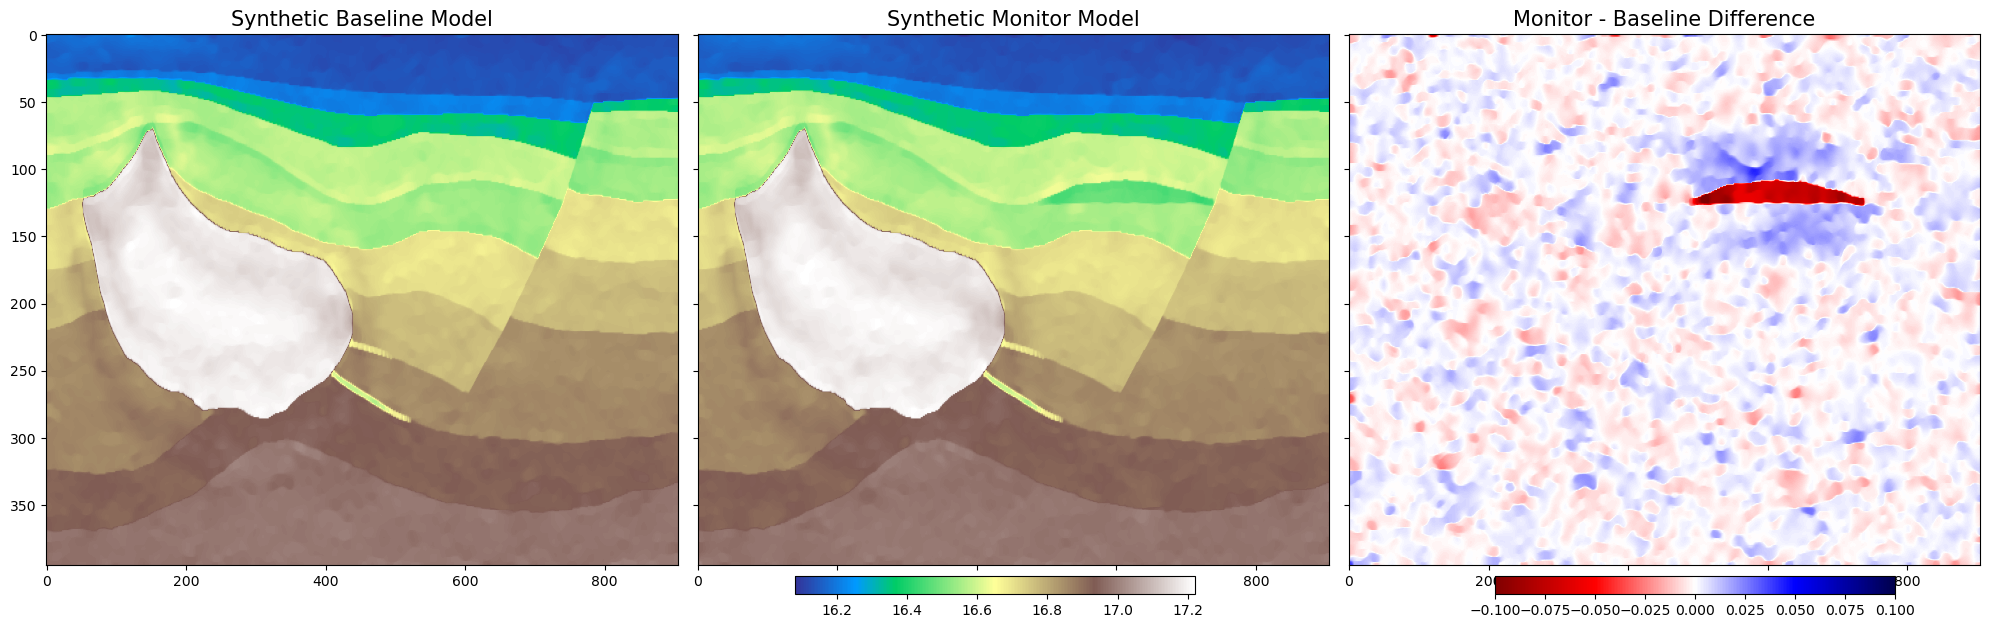

In [36]:
# data Loading
m_true = np.load('data/m_true.npy')
m1 = np.load('data/mpd3a.npy')
m2 = np.load('data/mpd3b.npy')
dif = m2 - m1
vmin, vmax = m1.min(), m1.max()

fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
ax = ax.flatten()
ax0 = ax[0].imshow(m1, vmin=vmin, vmax=vmax, cmap='terrain')
ax[0].set_title('Synthetic Baseline Model', fontsize=15)
ax[0].axis('tight');
ax[1].imshow(m2, vmin=vmin, vmax=vmax, cmap='terrain')
ax[1].set_title('Synthetic Monitor Model', fontsize=15)
ax[1].axis('tight');
ax2 = ax[2].imshow(dif, vmin=-0.1, vmax=0.1, cmap='seismic_r')
ax[2].set_title('Monitor - Baseline Difference', fontsize=15)
ax[2].axis('tight');
fig.tight_layout()
fig.subplots_adjust(bottom=0.5)
cbar_ax = fig.add_axes([0.4, 0.001, 0.2, 0.03])
fig.colorbar(ax0, cax=cbar_ax, orientation='horizontal')
fig.subplots_adjust(bottom=0.05)
cbar_ax = fig.add_axes([0.75, 0.001, 0.2, 0.03])
fig.colorbar(ax2, cax=cbar_ax, orientation='horizontal')

### Benchmark

Total time: 30.952183723449707sec


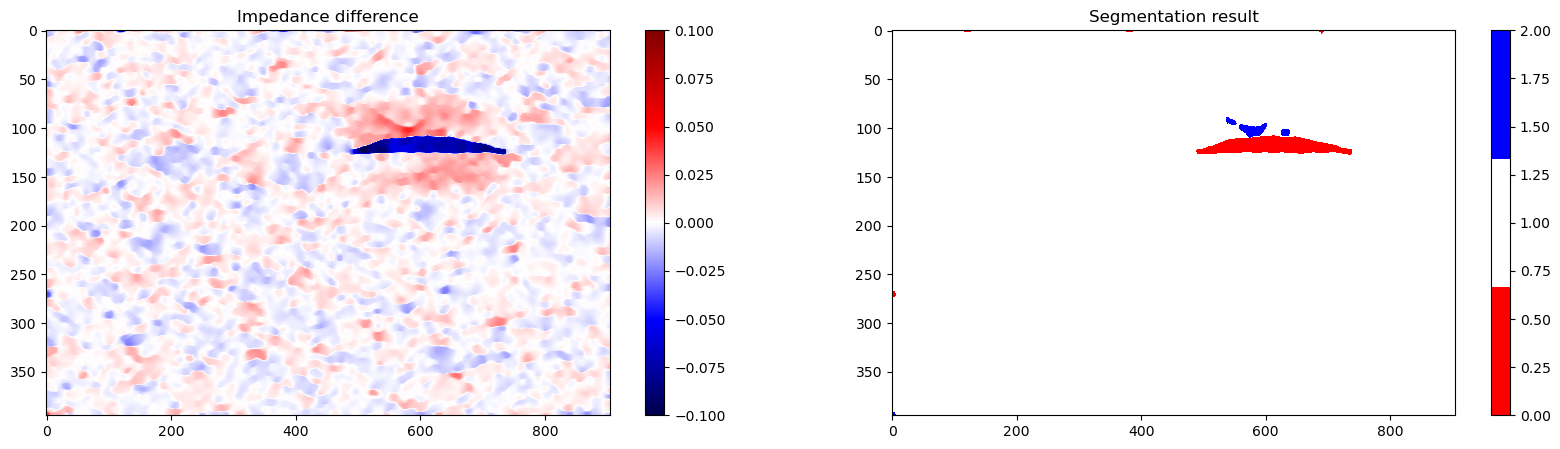

In [38]:
colors = [(1, 0, 0), (142, 142, 142), (0, 0, 1)]
cmap = LinearSegmentedColormap.from_list('segm', colors, N=3)
cl = np.array([-0.05, 0, 0.05])
sigma = 1.
alpha = 0.001

start = time.time()
segpd, segpd_classes = Segment(dif, cl, sigma, alpha, niter=50, show=False,
                               kwargs_simplex=dict(engine='numba', maxiter=10, call=False))
end = time.time()

print(f'Total time: {end - start}sec')

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
im0 = ax[0].imshow(dif, cmap='seismic', vmin=-0.1, vmax=0.1)
ax[0].axis('tight');
ax[0].set_title('Impedance difference')
im1 = ax[1].imshow(segpd_classes, cmap=cmap, vmin=0, vmax=2)
ax[1].axis('tight');
ax[1].set_title('Segmentation result')
fig.colorbar(im0, ax=ax[0], orientation='vertical')
fig.colorbar(im1, ax=ax[1], orientation='vertical')
plt.show()

### GPU Implementation

/home/romerojd/anaconda3/envs/4DProximal/lib/python3.8/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Total time: 4.005326509475708sec


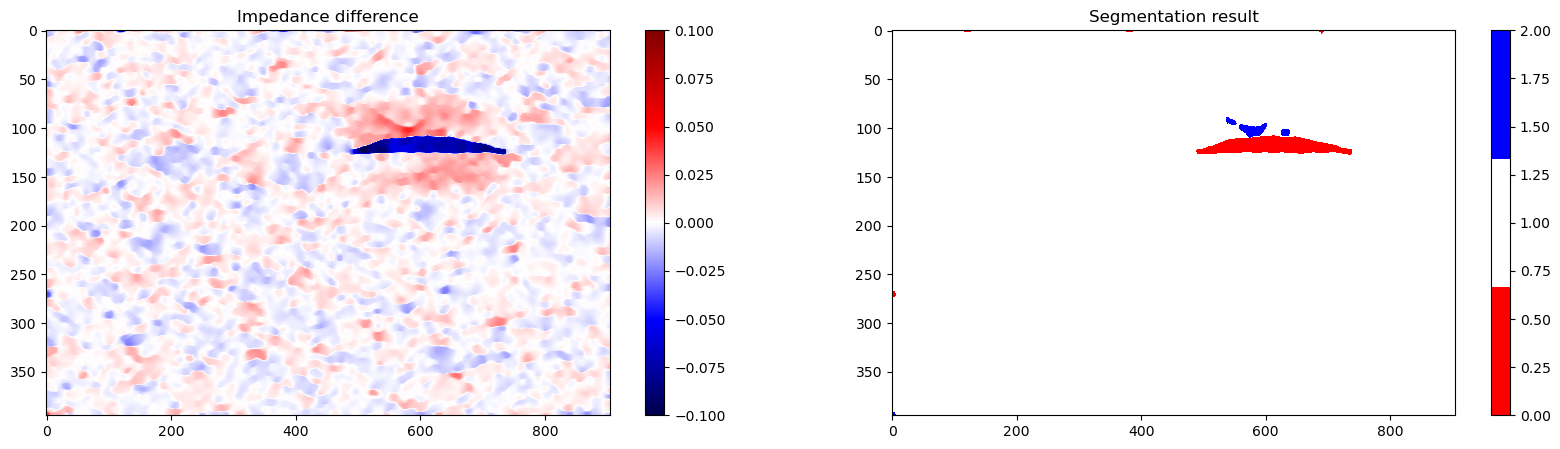

In [43]:
colors = [(1, 0, 0), (142, 142, 142), (0, 0, 1)]
cmap = LinearSegmentedColormap.from_list('segm', colors, N=3)
cl = np.array([-0.05, 0, 0.05])
sigma = 1.
alpha = 0.001

start = time.time()
segpd, segpd_classes = Segment_gpu(dif, cl, sigma, alpha, niter=50, show=False,
                                   kwargs_simplex=dict(maxiter=10, call=False))
end = time.time()

print(f'Total time: {end - start}sec')

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
im0 = ax[0].imshow(dif, cmap='seismic', vmin=-0.1, vmax=0.1)
ax[0].axis('tight');
ax[0].set_title('Impedance difference')
im1 = ax[1].imshow(segpd_classes, cmap=cmap, vmin=0, vmax=2)
ax[1].axis('tight');
ax[1].set_title('Segmentation result')
fig.colorbar(im0, ax=ax[0], orientation='vertical')
fig.colorbar(im1, ax=ax[1], orientation='vertical')
plt.show()

## Example 3: Bisection in the Primal-Dual segmentation algorithm of impedance model

### Benchmark

Total time: 41.75839948654175sec


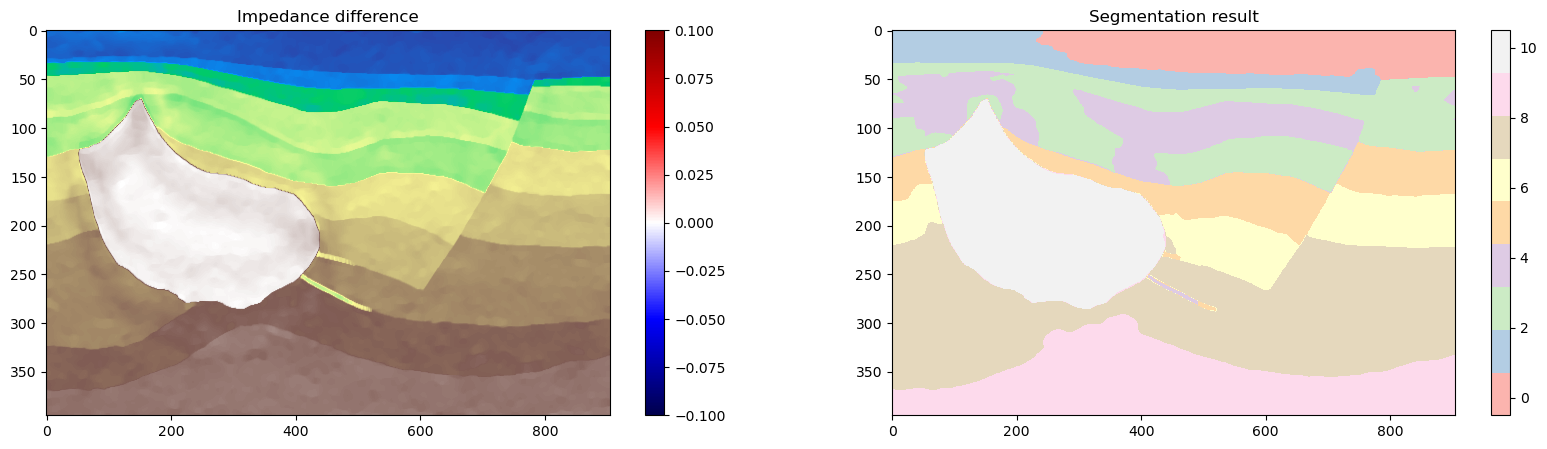

In [57]:
allcl = np.unique(m_true)
nclmin = 3000  #10000
cl = np.array(list(filter(lambda x: np.count_nonzero(m_true.ravel() == x) > nclmin, allcl)))
ncl = len(cl)

start = time.time()
segpd, segpd_classes = Segment(m1, cl, 20., 0.2, niter=50, show=False,
                               kwargs_simplex=dict(engine='numba', maxiter=10, call=False))
end = time.time()
print(f'Total time: {end - start}sec')

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax0 = ax[0].imshow(m1, vmin=vmin, vmax=vmax, cmap='terrain')
ax[0].axis('tight');
ax[0].set_title('Impedance difference')
im1 = ax[1].imshow(segpd_classes, cmap='Pastel1', vmin=-0.5, vmax=ncl - 0.5, )
ax[1].axis('tight');
ax[1].set_title('Segmentation result')
fig.colorbar(im0, ax=ax[0], orientation='vertical')
fig.colorbar(im1, ax=ax[1], orientation='vertical')
plt.show()

### GPU Implementation

/home/romerojd/anaconda3/envs/4DProximal/lib/python3.8/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Total time: 12.936389207839966sec


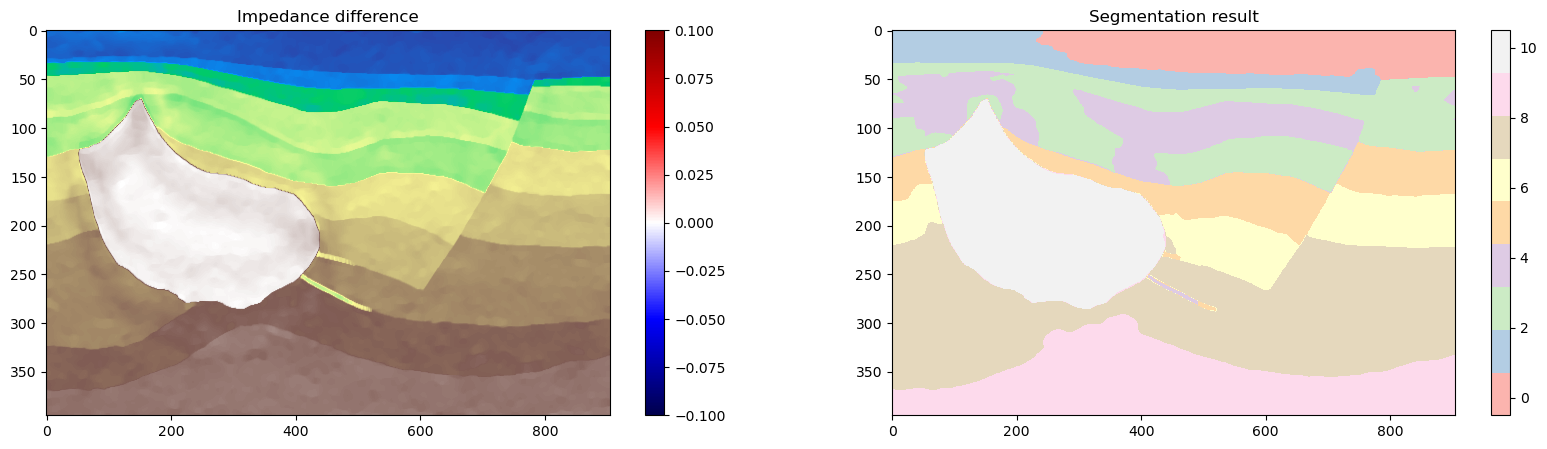

In [55]:
allcl = np.unique(m_true)
nclmin = 3000  #10000
cl = np.array(list(filter(lambda x: np.count_nonzero(m_true.ravel() == x) > nclmin, allcl)))
ncl = len(cl)
sigma = 1.
alpha = 0.001

start = time.time()
segpd, segpd_classes = Segment_gpu(m1, cl, 20., 0.2, niter=50, show=False,
                                   kwargs_simplex=dict(maxiter=10, call=False))
end = time.time()

print(f'Total time: {end - start}sec')

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax0 = ax[0].imshow(m1, vmin=vmin, vmax=vmax, cmap='terrain')
ax[0].axis('tight');
ax[0].set_title('Impedance difference')
im1 = ax[1].imshow(segpd_classes, cmap='Pastel1', vmin=-0.5, vmax=ncl - 0.5, )
ax[1].axis('tight');
ax[1].set_title('Segmentation result')
fig.colorbar(im0, ax=ax[0], orientation='vertical')
fig.colorbar(im1, ax=ax[1], orientation='vertical')
plt.show()